# Mini Reto 007 del grupo Python para Trading

# Backtrader - Estrategia de reversión a la media RSI 25/75 


Trás el Mini-Reto 006 continuamos con Backtrader, implementando una estrategía bien conocida que incrementa un poco su complejidad.

Se trata de la estrategia RSI 25/75 publicada por Larry Connors y Cesar Álvarez en su libro “High Probability ETF Trading: 7 Professional Strategies to Improve Your ETF Trading”. 

Utiliza el índice de fuerza relativa RSI para medir cuando un activo se encuentra sobrevendido durante una tendencia alcista o sobrecomprado durante una tendencia bajista. Sugieren bajar el período de tiempo para el indicador RSI de su nivel habitual de 14 a 4, para aumentar significativamente el número de operaciones, con un indicador más "nervioso".

El sistema utiliza una de media móvil simple, con un periodo de 200, para determinar la tendencia a largo plazo. 

En mercado con tendencia alcista, es decir precio de cierre por encima de la media de 200 días, se abre posición larga cuando el indicador RSI cae por debajo 25. Se cierra la posición cuando el RSI cruza por encima de 55. 

En mercado bajista, abre posición corta cuando el RSI cruza por encima 75 y cierra cuando el RSI cae por debajo 45.

Además en vez de fijar un número fijo de acciones, queremos establecer nuestra posición como un porcentaje dado del valor de nuestra cartera. Esto permite reinvertir los beneficios, tendríamos un interés compuesto.

Para ello vamos a definir un `sizer` es decir una [clase de Backtrader](https://www.backtrader.com/docu/sizers/sizers/) que permite calcular el tamaño de cada orden en base a una seríe de parametros que definimos. En este caso en base al porcentaje definido, el valor de la cartera y el precio del activo en el momento del cruce.

Para hacerlo más cercano a la realidad debes incorporar una comisión de 0.0035 USD por acción.

Y como gestión de capital invertir el 90% del valor de la cartera en cada operación.



Partiendo del código que hay a continuación:

- 1) Diseñar la estrategia en base a los indicadores
- 2) Configurar el entorno de backtrader
- 3) Ejecutar el backtest con la estrategia
- 4) Optimizar los parametros de periodos del RSI y SMA para máximizar el Sharpe.
- 5) Ejecutar el backtest con los parametros obtenidos
- 6) Analizar los resultados con Pyfolio


In [1]:
# Importamos las librerías y configuramos la visualización
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf
import backtrader as bt
from math import floor
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'

In [21]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'

In [3]:
# Descargamos los datos, en este caso usaremos Microsoft

symbol = 'AAPL'
quotes = yf.download(symbol, start='2010-1-1', end='2020-11-25')

[*********************100%***********************]  1 of 1 completed


In [4]:
# Clase heredada de bt.Sizer al que le pasamos el porcentaje 
# que queremos estar expuestos

class PercentValue(bt.Sizer):
    params = (('percent', .90),)

    def _getsizing(self, comminfo, cash, data, isbuy):
        # Calculamos la posición diviendo el porcentaje deseado 
        # del valor de la cartera entre el precio del activo
        return floor((self.broker.get_value() * self.params.percent / data) )

In [5]:
# Diseñamos la estrategia


class cruceRSI_(bt.Strategy):
    params = dict(sma_period=200,
                  rsi_period=4
                  )

    def __init__(self):
        # Definimos los indicadores
        self.sma = bt.ind.SMA(period=self.p.sma_period)
        self.rsi = bt.indicators.RSI_SMA(
            self.data.close, period=self.p.rsi_period, safediv=True, plotname='RSI')

        # Definimos los distintos cruces
        self.crossdown = bt.ind.CrossOver(
            self.rsi, bt.LineNum(25.0), plotname='Sobreventa')
        self.crossup = bt.ind.CrossOver(
            self.rsi, bt.LineNum(75.0), plotname='Sobrecompra')
        self.crossdown_close = bt.ind.CrossOver(self.rsi, bt.LineNum(55.0))
        self.crossup_close = bt.ind.CrossOver(self.rsi, bt.LineNum(45.0))

    def next(self):
        if not self.position:  # Si no hay una operacion abierta
            # si el RSI cruza hacia arriba y la tendecia es bajista
            if self.crossup == 1 and self.data.close < self.sma:
                self.sell()         # Se entra en corto
            # si el RSI cruza hacia abajo y la tendecia es alcista
            if self.crossdown == -1 and self.data.close > self.sma:
                self.buy()        # Se entra en largo
        # si hay posición larga y cruza el valor de cierre hacia abajo
        elif self.position.size > 0 and self.crossup_close == -1:
            self.close()  # cierra posición
        # si hay posición corta y cruza el valor de cierre hacia arriba
        elif self.position.size < 0 and self.crossdown_close == 1:
            self.close()  # cierra posición

In [6]:
# Definimos los parametros de la estrategia

cash = 10000
exposure = .90
sma_period = 200
rsi_period = 4

# Configuramos el entorno

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=quotes)
cerebro.adddata(data)

# Añadimos la estrategia
cerebro.addstrategy(cruceRSI_, sma_period=sma_period,
                    rsi_period=rsi_period) 
# Añadimos el sizer
cerebro.addsizer(PercentValue, percent=exposure)  
# Añadimos la comisión de 0.0035 USD por acción
cerebro.broker.setcommission(commission=0.0035, margin=True)

# Añadimos los analizadores
cerebro.addanalyzer(bt.analyzers.Returns, _name='return')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

# Ejecutamos el backtesting
results = cerebro.run()

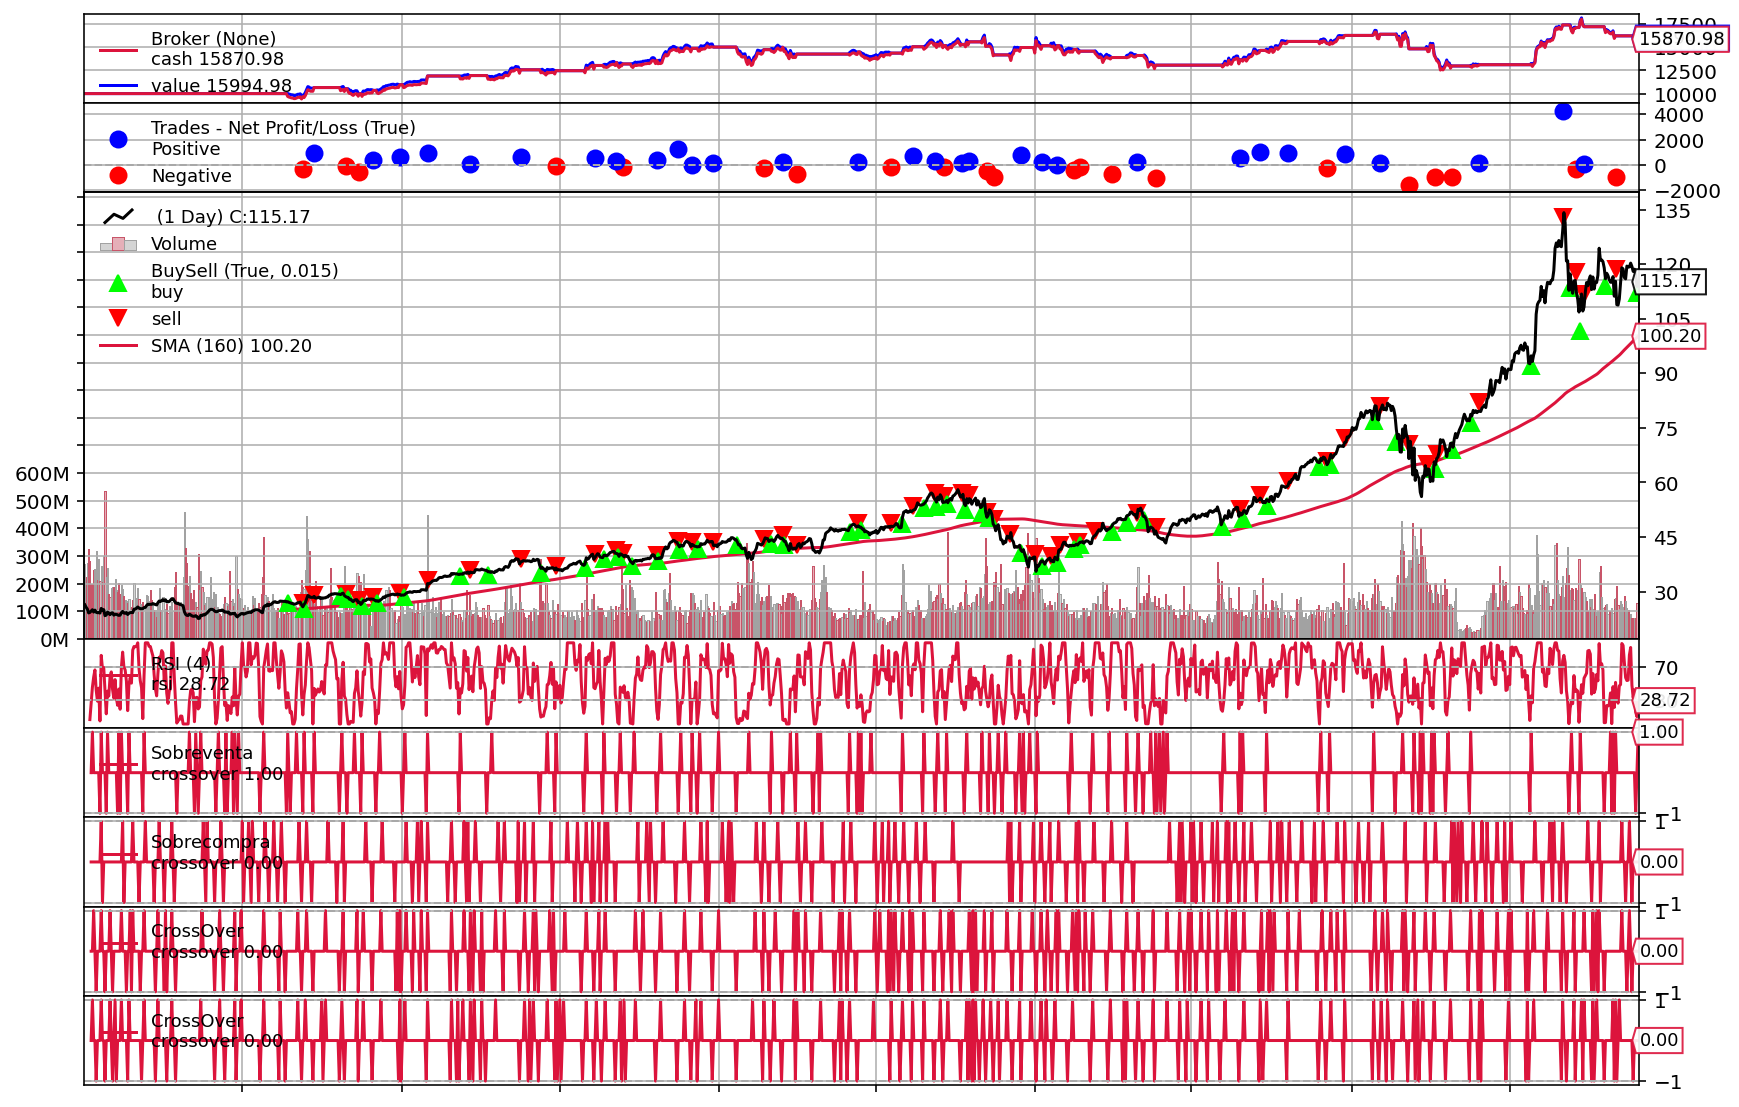

In [22]:
cerebro.plot(iplot=False);

## Vamos a optimizar los periodos

In [8]:
## Definimos los parametros de la estrategia

cash = 10000
exposure = .90
sma_range = range(100, 301, 10)
rsi_range = range(2, 10)

## Configuramos el entorno

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

# Vamos a usar la mitad de la muestra solo para optimizar (in sample)
data = bt.feeds.PandasData(dataname=quotes[:'2015'])
cerebro.adddata(data)


cerebro.optstrategy(cruceRSI_, sma_period=sma_range, rsi_period=rsi_range) # Determinamos la estrategia
cerebro.addsizer(PercentValue, percent=exposure)  # Añadimos el sizer
cerebro.broker.setcommission(commission=0.0035, margin=True) # Añadimos la comisión de 0.0035 USD por acción

cerebro.addanalyzer(bt.analyzers.Returns, _name='target')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

## Ejecutamos el backtesting

results = cerebro.run()

In [9]:
# Recuperamos los datos de las simulaciones de los analizadores

info = []
for result in results:
    info += [{'sma_period': result[0].params.sma_period, 
              'rsi_period': result[0].params.rsi_period, 
              'returns': result[0].analyzers.target.get_analysis()['ravg'],
              'sharpe': result[0].analyzers.sharpe.get_analysis()['sharperatio']}]

Retornos


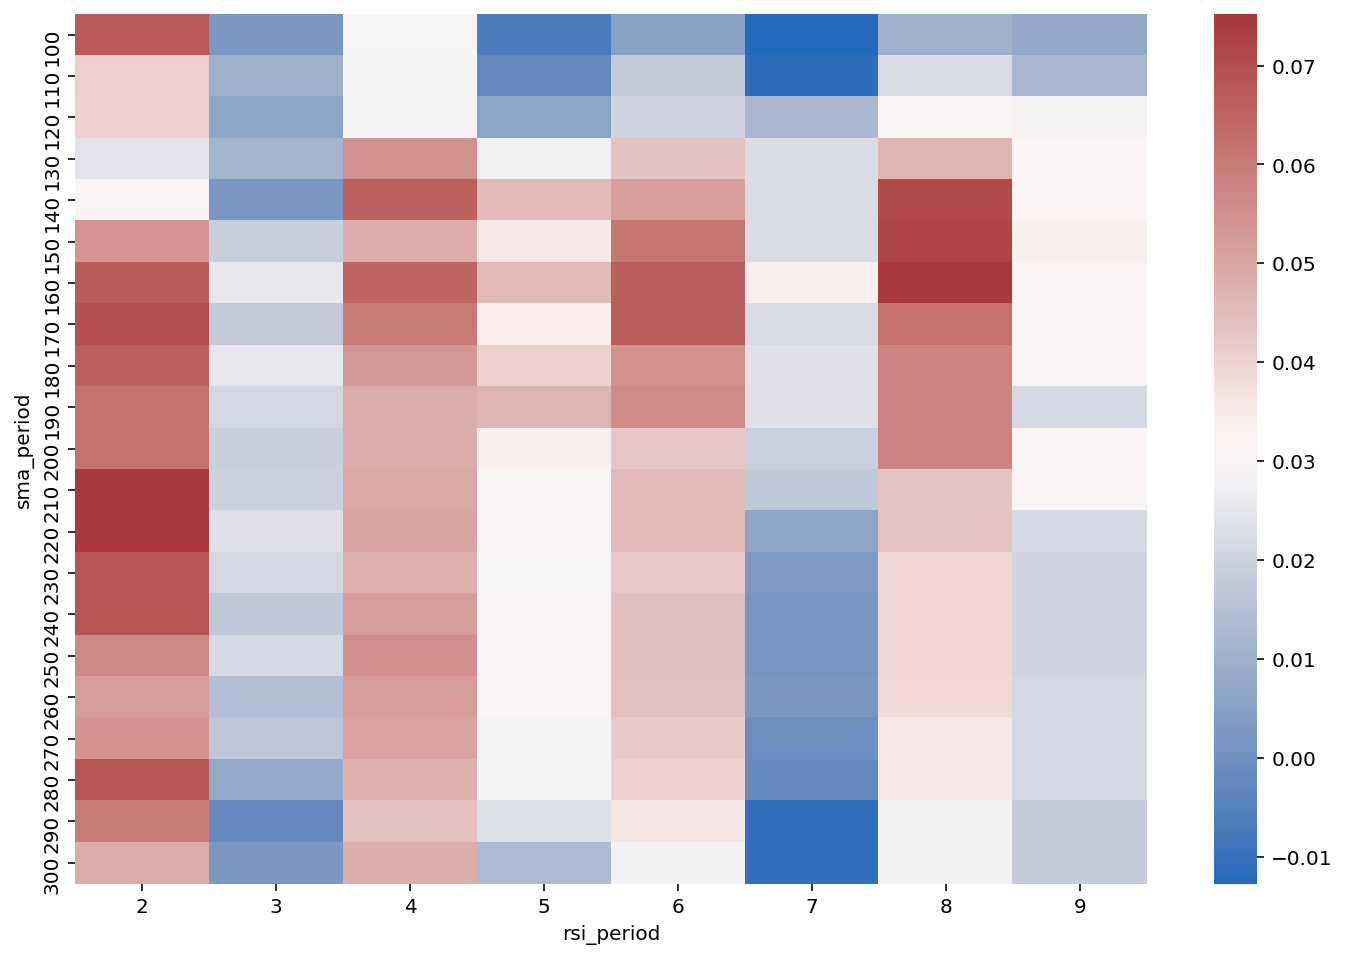

In [23]:
# Pasamos a los resultados a dataframe y visualizamos
resultados = pd.DataFrame(info)

retornos = resultados.pivot('sma_period', 'rsi_period', 'returns').mul(100)
sharpe = resultados.pivot('sma_period', 'rsi_period', 'sharpe')

print("Retornos")
sns.heatmap(retornos, cmap="vlag");

Sharpe


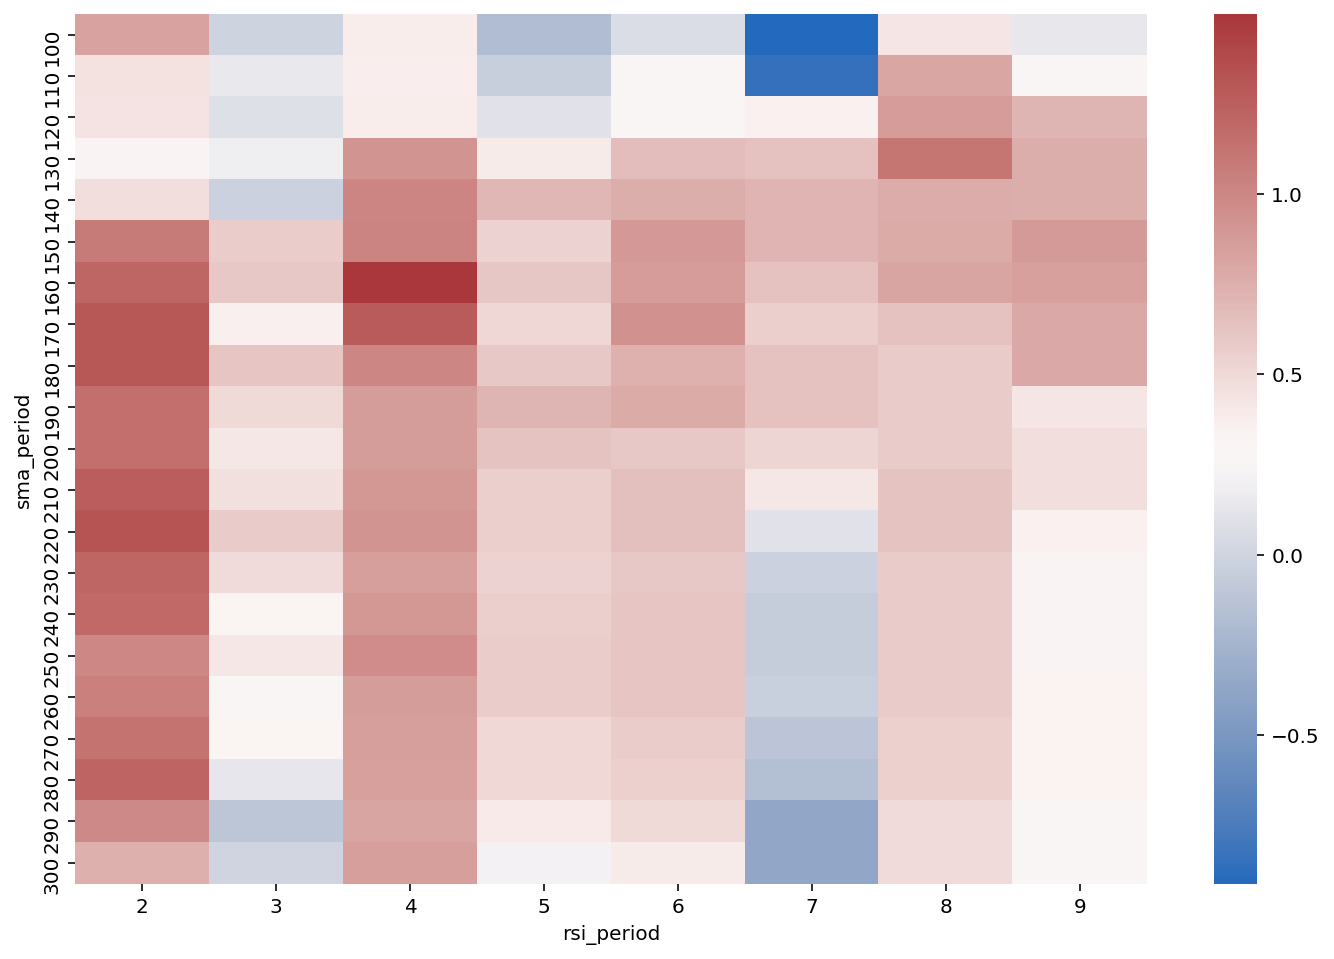

In [24]:
print("Sharpe")
sns.heatmap(sharpe, cmap="vlag");

In [12]:
sma_period_opt = sharpe.stack().idxmax()[0]
rsi_period_opt = sharpe.stack().idxmax()[1]

print(f"Máximo Sharpe es {sharpe.stack().max().round(2)}, para un periodo de RSI de {sma_period_opt} y un periodo de SMA de {rsi_period_opt}.")

Máximo Sharpe es 1.5, para un periodo de RSI de 160 y un periodo de SMA de 4.


### Simulamos los parametros optimizados, incluyendo en esta ocasión el analizador de pyfolio

In [13]:
## Definimos los parametros de la estrategia

cash = 10000
exposure=.90
sma_period = sma_period_opt
rsi_period = rsi_period_opt

## Configuramos el entorno

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)


# Para comprobar el resultado de la optimización usamos el resto de la muestra (out sample)
data = bt.feeds.PandasData(dataname=quotes["2016":])
cerebro.adddata(data)


cerebro.addstrategy(cruceRSI_, sma_period=sma_period, rsi_period=rsi_period) # Determinamos la estrategia
cerebro.addsizer(PercentValue, percent=exposure)  # Añadimos el sizer
cerebro.broker.setcommission(commission=0.0035, margin=True) # Añadimos la comisión de 0.0035 USD por acción

cerebro.addanalyzer(bt.analyzers.Returns, _name='target')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

## Ejecutamos el backtesting

results = cerebro.run()

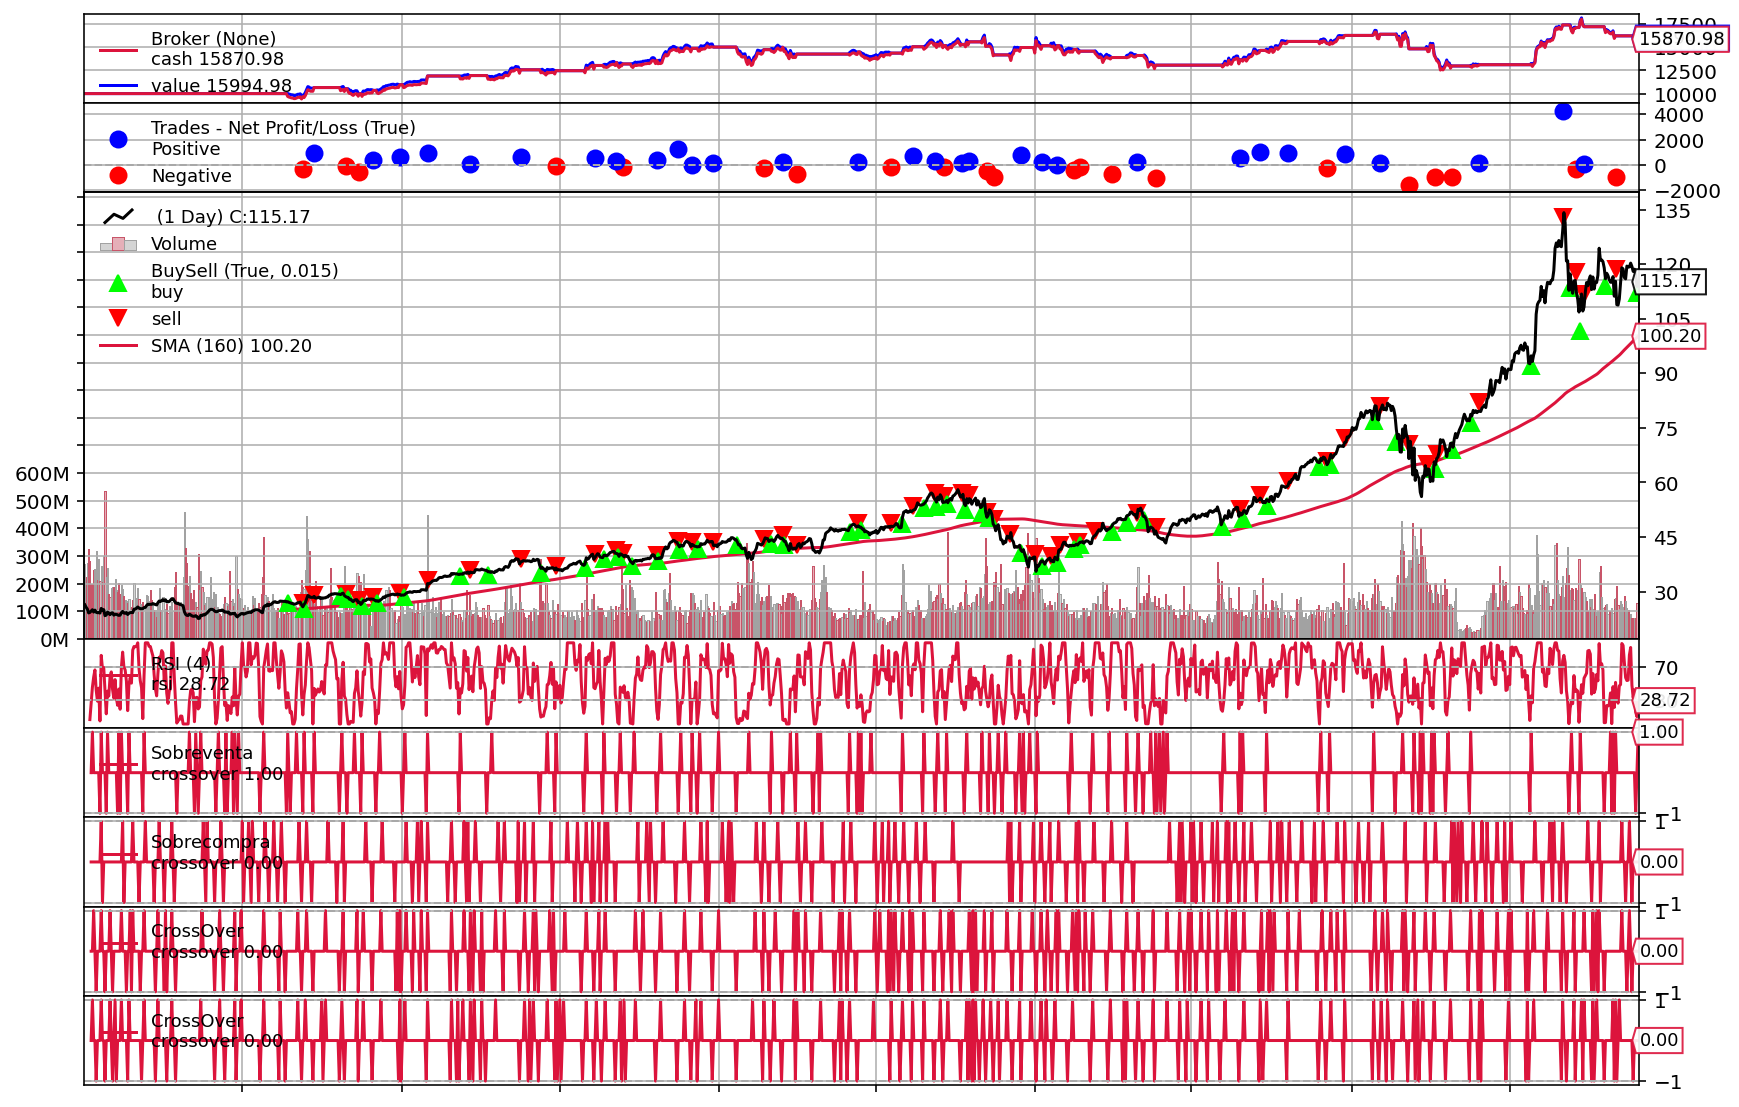

In [25]:
cerebro.plot(iplot=False);

In [26]:
sharpe = round(result[0].analyzers.sharpe.get_analysis()['sharperatio'], 2)

print(f"El Sharpe de la simulación out sample es {sharpe}")

El Sharpe de la simulación out sample es 0.28


## Analizamos los resultados

In [17]:
# Definimos una función para visualizar los resultados del análisis pyfolio

def analisis(results, strategy_id=0):
    pyfolio_analyzer = results[strategy_id].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
    %matplotlib inline
    return pf.create_full_tear_sheet(returns, transactions=transactions, positions=positions)

Start date,2016-01-04
End date,2020-11-24
Total months,58
,Backtest
Annual return,10.067%
Cumulative returns,59.95%
Annual volatility,17.825%
Sharpe ratio,0.63
Calmar ratio,0.41
Stability,0.66
Max drawdown,-24.39%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.39,2020-01-29,2020-04-14,2020-08-21,148
1,20.72,2018-11-01,2019-05-20,2020-01-28,324
2,13.78,2017-12-18,2018-02-08,2018-08-30,184
3,12.96,2020-09-22,2020-11-23,NaT,NaN
4,7.25,2016-10-25,2016-11-11,2016-12-13,36


Top 10 long positions of all time,max
Data0,3.40%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,3.40%


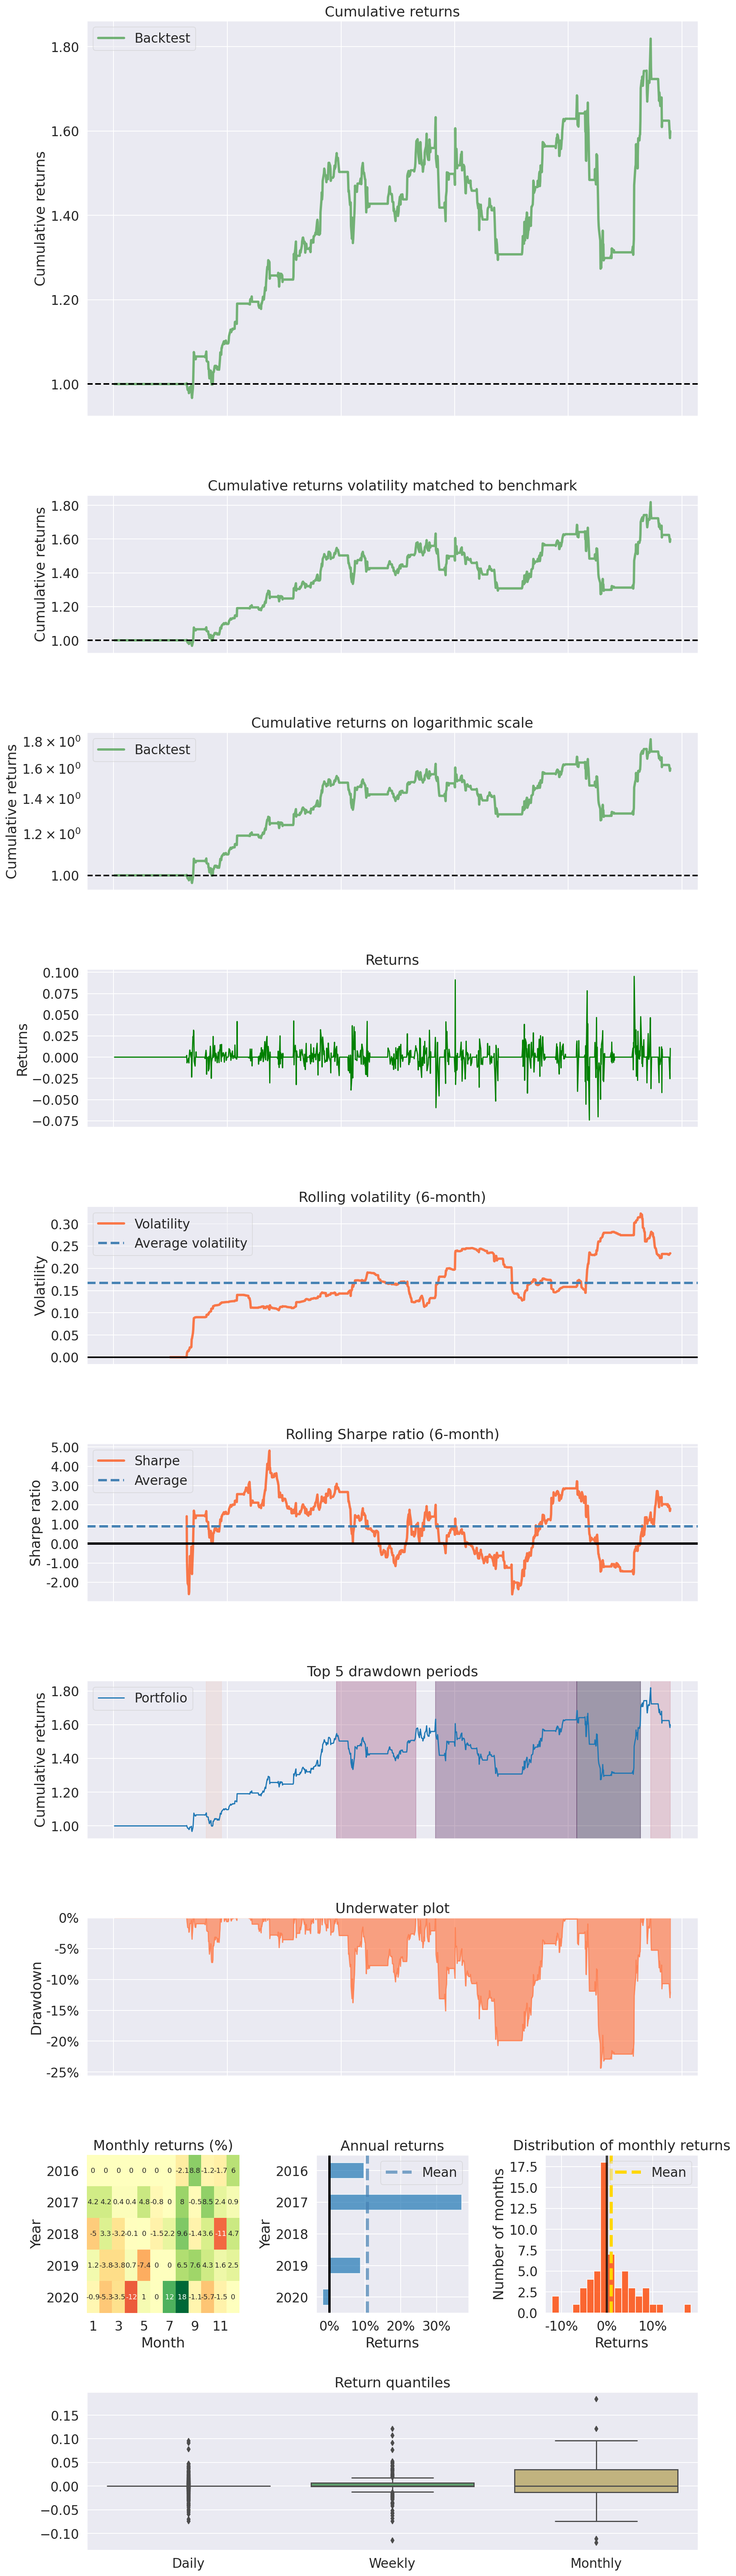

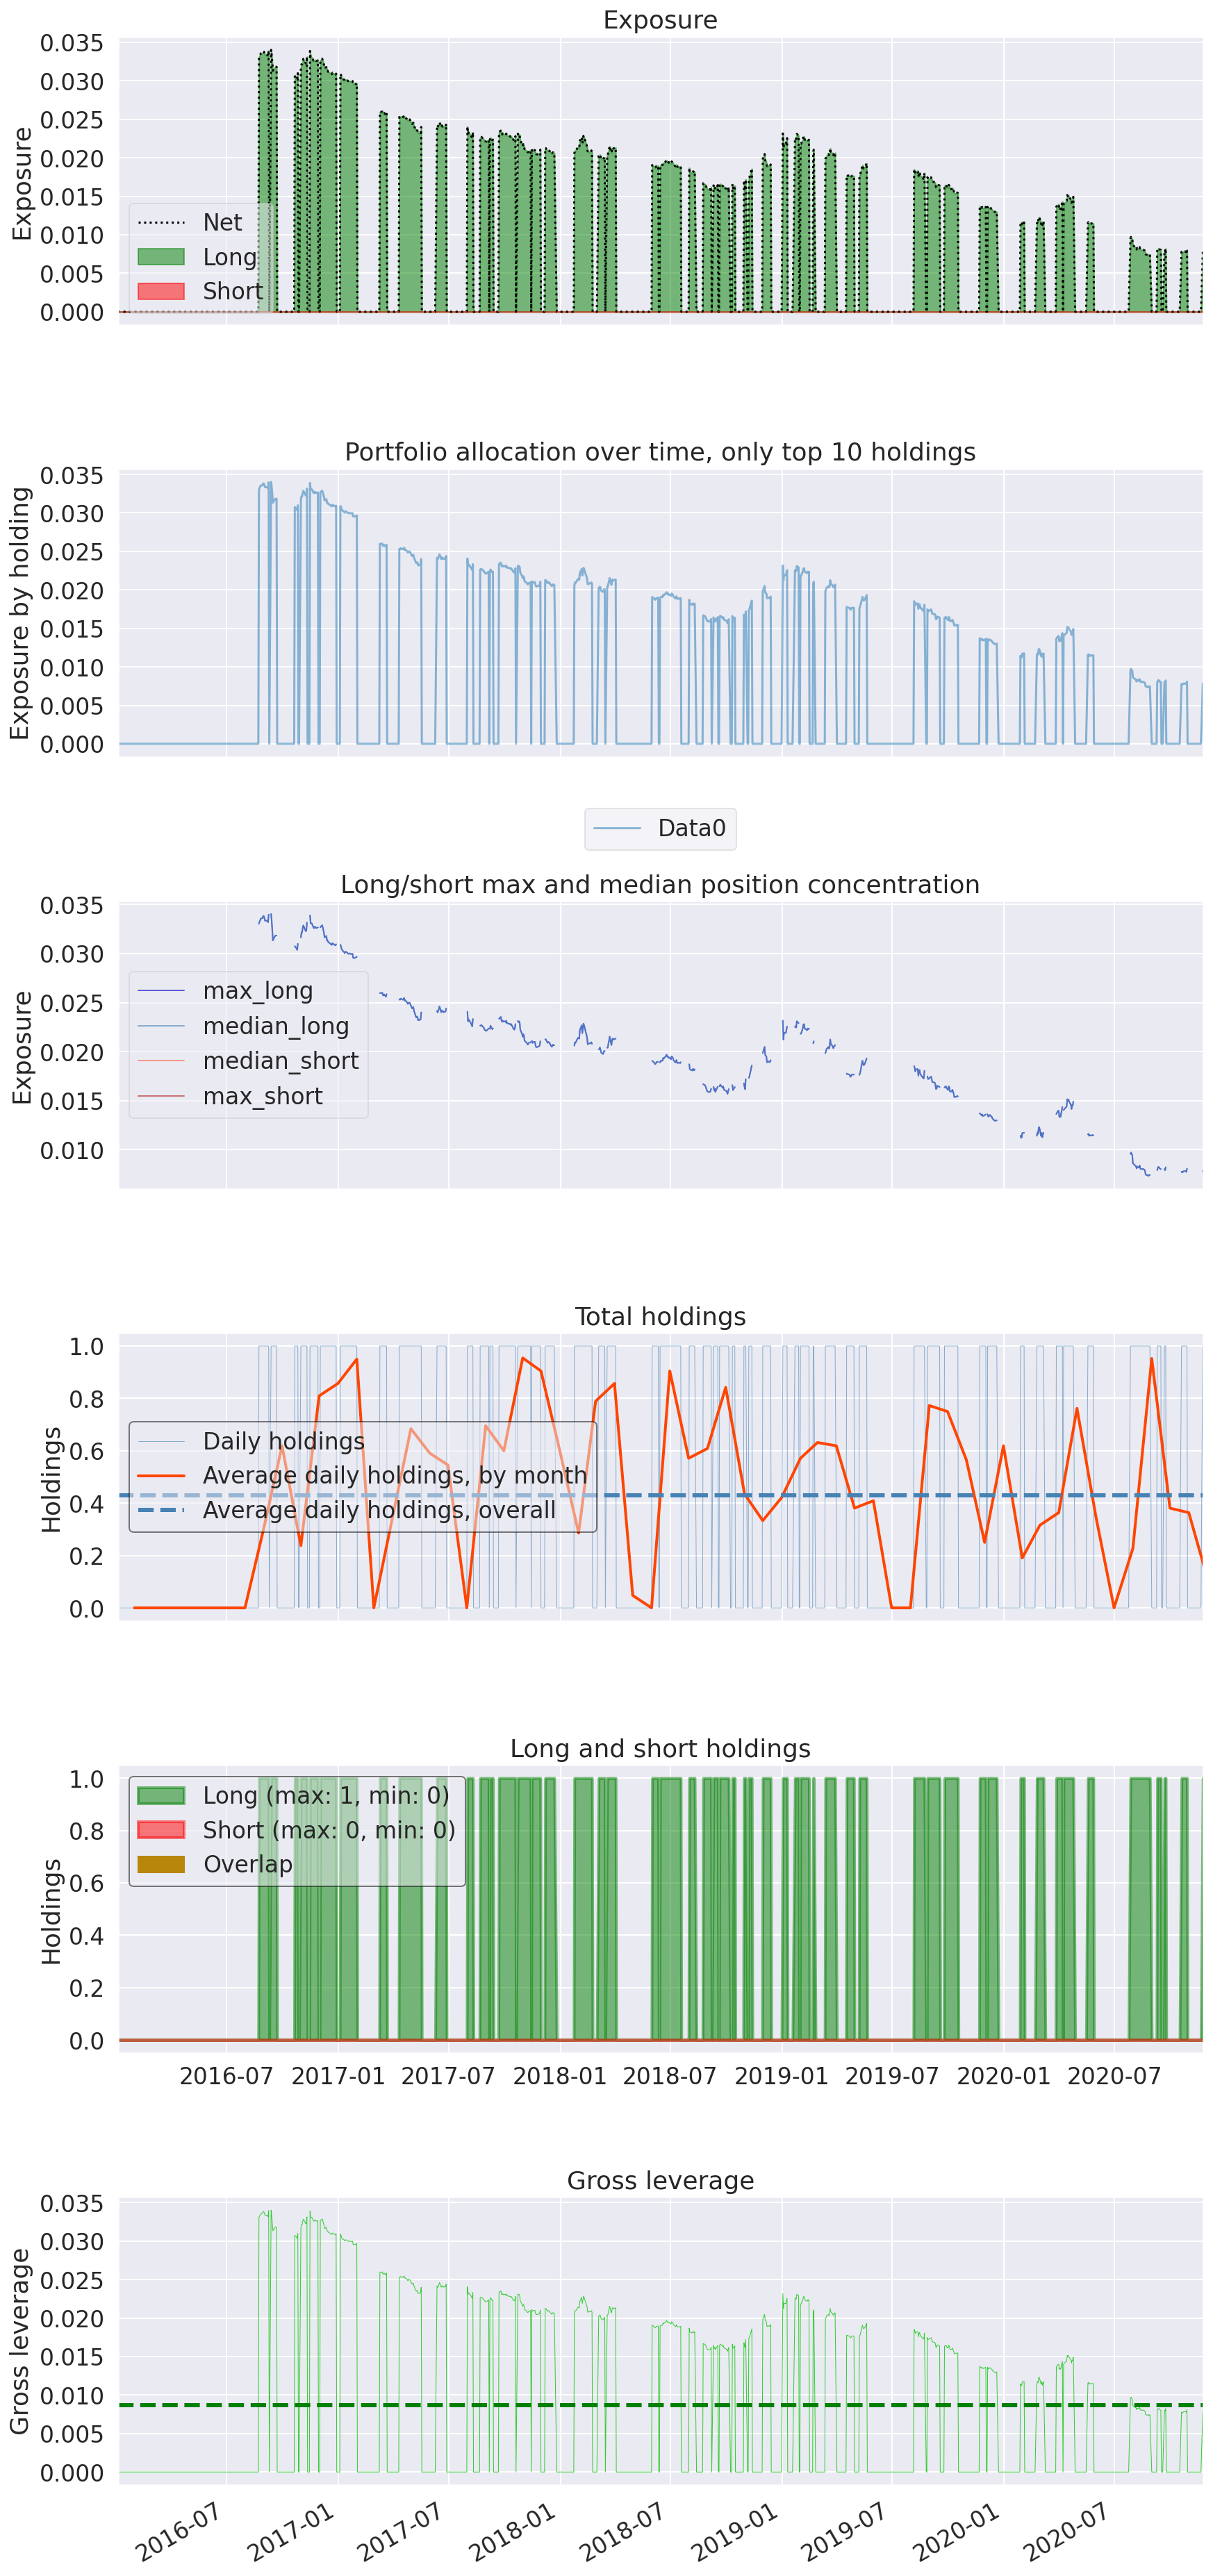

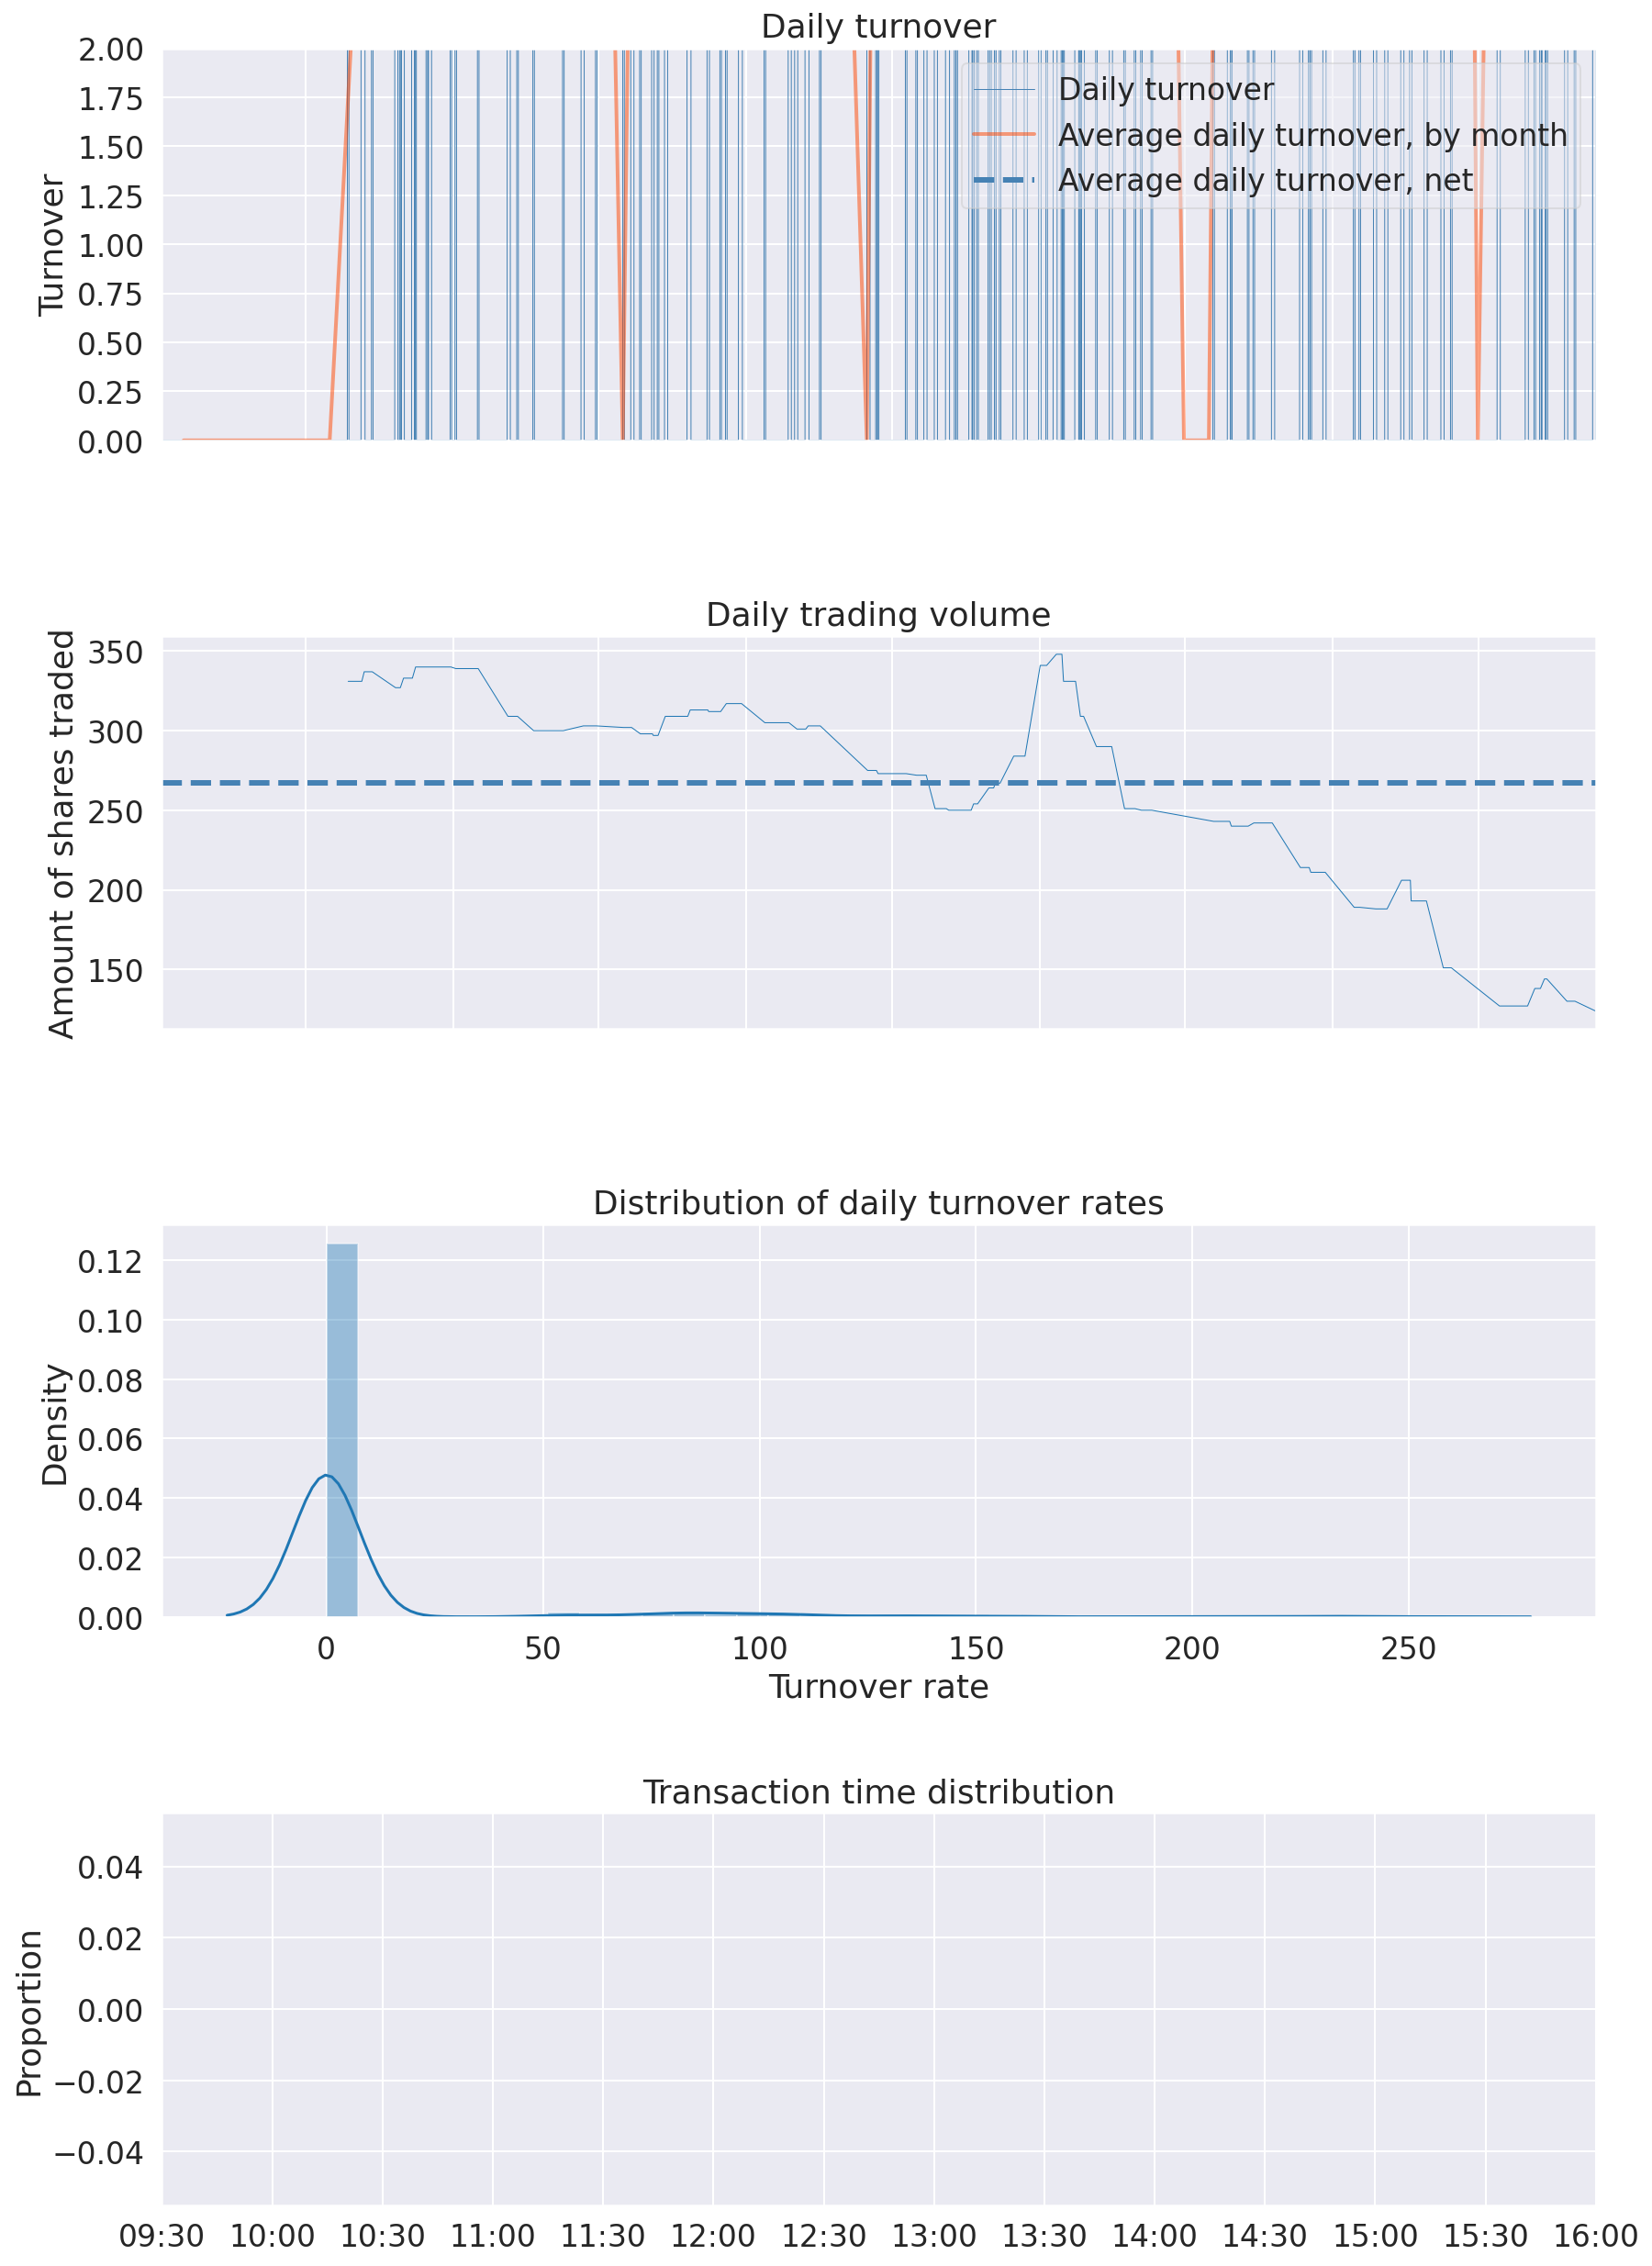

In [18]:
# Visualizamos el análisis

analisis(results)